In [2]:
import numpy as np
import pandas as pd
from glob import glob
import os
import pathlib
import tensorflow as tf
import keras
import keras_tuner as kt

#models
from tensorflow.keras.applications import EfficientNetB0

#preproces
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt

from collections import Counter
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau


# Data Load 

In [3]:
imgs = glob(r'/kaggle/input/mushrooms-classification-common-genuss-images/Mushrooms/*/*')
labels = [el.split('/')[5] for el in imgs ]
SIZE = 220

# Visualisation

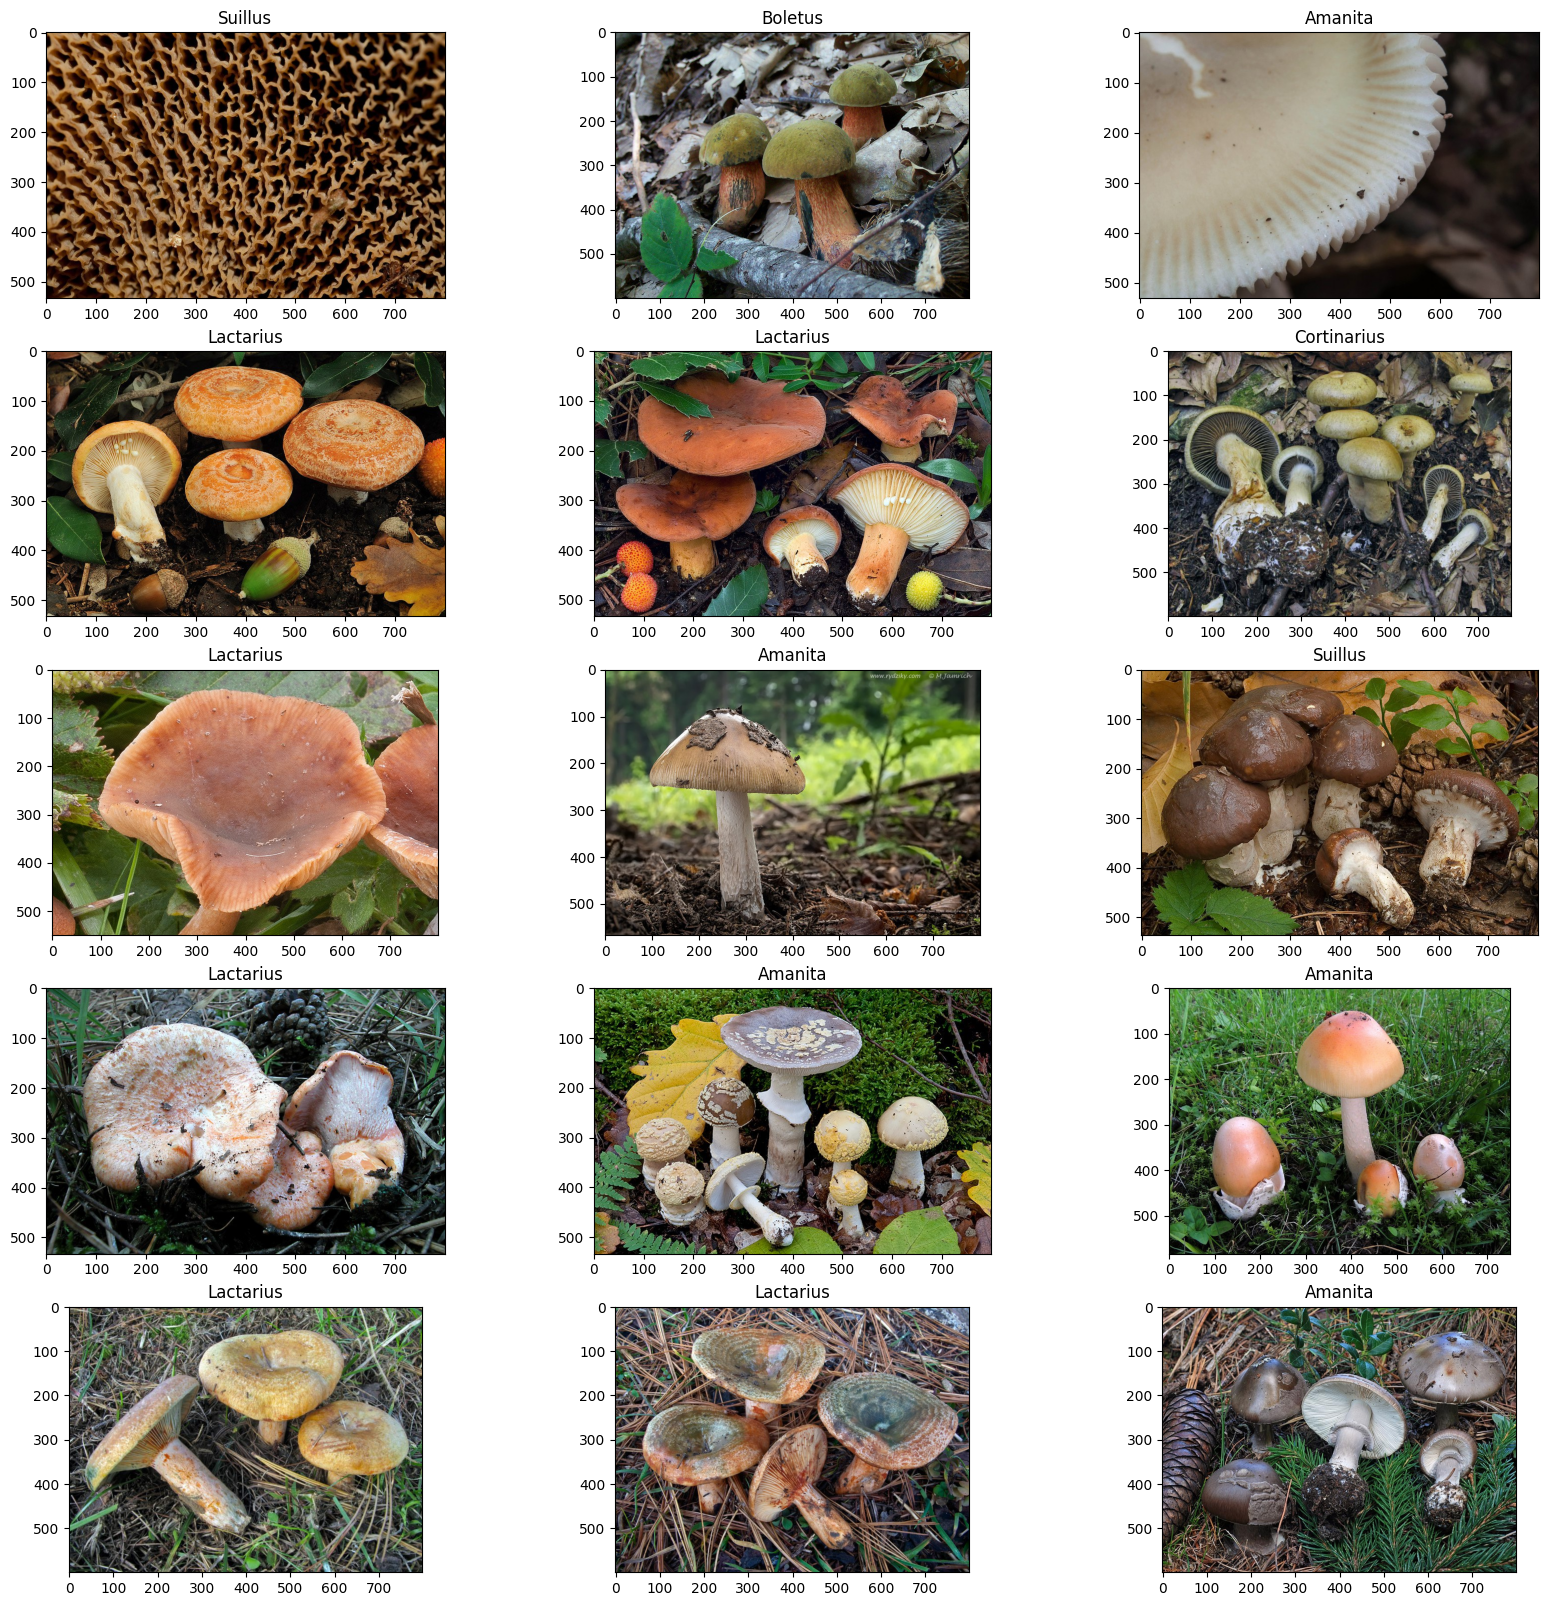

In [4]:
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
fig.subplots_adjust()
im_list = np.random.choice(imgs, 15)
for axi, im in zip( ax.flat, im_list):
    axi.set_title(im.split('/')[5],)
    axi.imshow(plt.imread(im), )
   


## Class Distribution

In [4]:
distribution_dict = {k:np.round(v*100/len(labels), 2) for k,v in Counter(labels).items()} 
distribution_dict

{'Entoloma': 5.42,
 'Suillus': 4.63,
 'Hygrocybe': 4.71,
 'Agaricus': 5.26,
 'Amanita': 11.17,
 'Lactarius': 23.28,
 'Russula': 17.1,
 'Boletus': 15.98,
 'Cortinarius': 12.45}

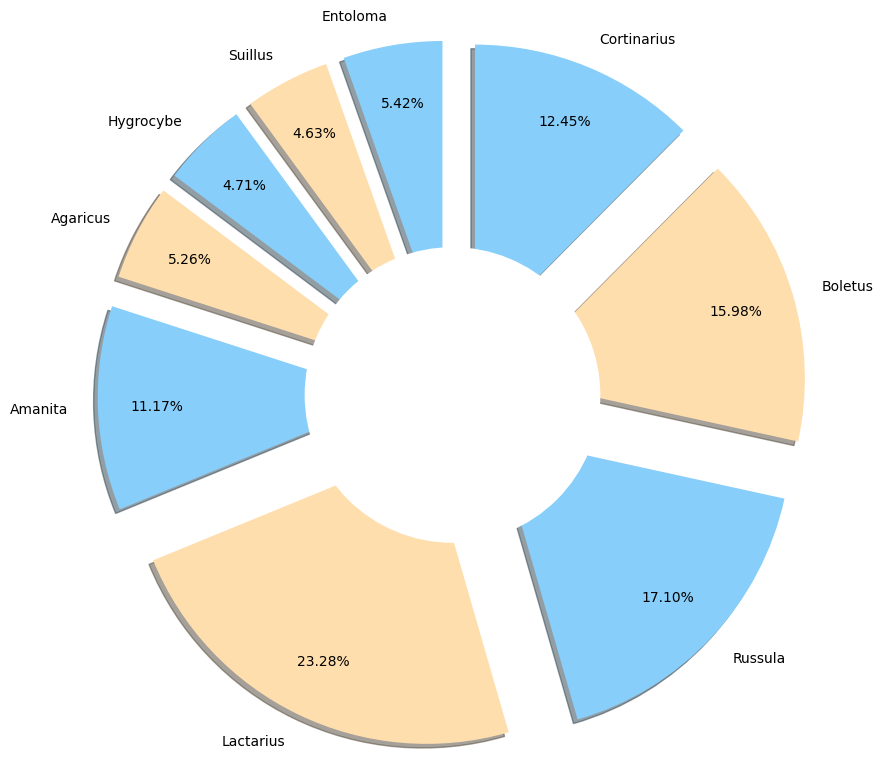

In [5]:
distribution_dict = {k:np.round(v*100/len(labels), 2) for k,v in Counter(labels).items()} 
tab = {'lightskyblue': '#87CEFA', 'navajowhite': '#FFDEAD'}

plt.pie.DonutSize=9
plt.pie(distribution_dict.values(), labels=distribution_dict.keys(),radius=2, colors=tab, shadow=True, startangle=90, autopct='%1.2f%%',
       pctdistance=0.80, explode=[0.4 for el in range(9)])

hole = plt.Circle((0, 0), 1.0, facecolor='white')
plt.gcf().gca().add_artist(hole)
 
plt.show()

## Test Train Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.33, random_state=14, stratify=labels)
train = pd.DataFrame(list(zip(X_train,y_train)), columns =['X','y'])
test = pd.DataFrame(list(zip(X_test,y_test)), columns =['X','y'])

In [27]:



datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True, 
        brightness_range=(1.0, 0.8),)
valid_gen = ImageDataGenerator(rescale=1./255)

In [28]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [29]:
train_gen = datagen.flow_from_dataframe(train, x_col='X', y_col="y", target_size=(SIZE, SIZE), shuffle=True)
test_gen = valid_gen.flow_from_dataframe(test, x_col='X', y_col="y", target_size=(SIZE, SIZE))

Found 4498 validated image filenames belonging to 9 classes.
Found 2216 validated image filenames belonging to 9 classes.


## Build up EFB0 model 

In [30]:
def build_model(num_classes=9, shape=(SIZE,SIZE,3)):
    inputs = tf.keras.layers.Input(shape=shape)
    model = EfficientNetB0(include_top=False,
        weights='imagenet',
        input_tensor=inputs, # !
        input_shape=None,
        pooling=None)
    
    model.trainable = True

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)
    top_dropout_rate = 0.4
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)
    model = keras.Model(inputs, outputs, name="EfficientNetB0")
    # Compile
    loss = tf.keras.losses.CategoricalFocalCrossentropy(
        alpha=0.25,
        gamma=2.0,
        from_logits=False)
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
 
    model.compile(loss=loss, metrics=['accuracy'], optimizer=optimizer)
    
    
    
    return model

In [31]:
model = build_model()
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True, start_from_epoch=20)


In [32]:
epoch = 40
history = model.fit(train_gen, validation_data=test_gen, epochs=epoch, callbacks=[early_stop] )

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.4253 - loss: 0.4532 - val_accuracy: 0.1710 - val_loss: 0.4268
Epoch 2/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 84s 573ms/step - accuracy: 0.6667 - loss: 0.1753 - val_accuracy: 0.2329 - val_loss: 0.4038
Epoch 3/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 85s 576ms/step - accuracy: 0.7398 - loss: 0.1303 - val_accuracy: 0.2157 - val_loss: 0.4204
Epoch 4/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 84s 567ms/step - accuracy: 0.7595 - loss: 0.1191 - val_accuracy: 0.2008 - val_loss: 1.6921
Epoch 5/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 84s 570ms/step - accuracy: 0.7683 - loss: 0.1163 - val_accuracy: 0.3533 - val_loss: 0.4501
Epoch 6/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 84s 567ms/step - accuracy: 0.7982 - loss: 0.0991 - val_accuracy: 0.3863 - val_loss: 0.3244
Epoch 7/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 85s 580ms/step - accuracy: 0.8412 - loss: 0.0718 - val_accuracy: 0.7938 - val_loss: 0.0979
Epoch 8/40
141/141 ━━━━━━━━━━━━━━━━━━━━ 84s 570ms/step - accuracy: 0.8465 - loss: 0.0680 - val_a

## Metrics

In [34]:
def show_history(history):
    plt.figure(figsize=(18,8))

    plt.suptitle('Loss and Accuracy Plots', fontsize=18)

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)

    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.show()

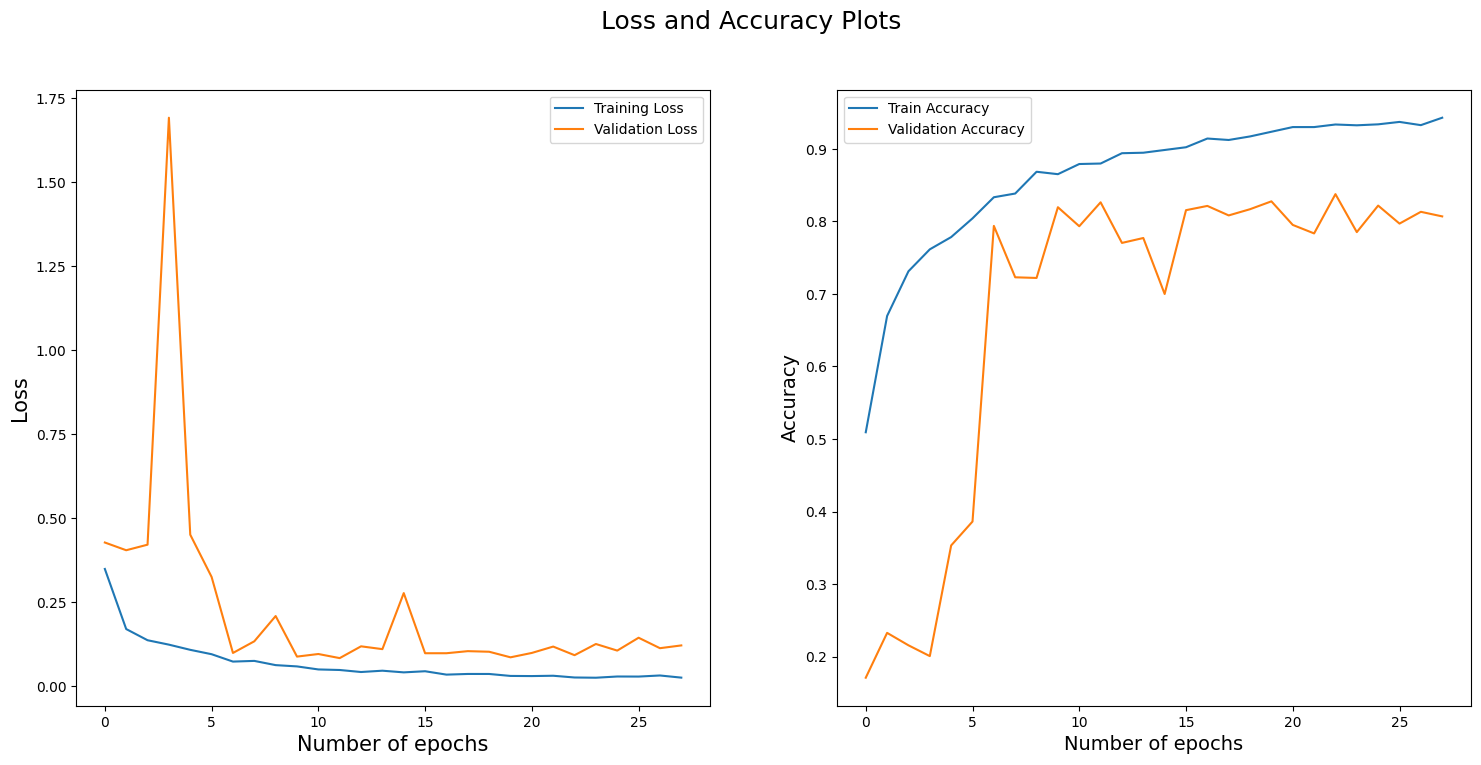

In [35]:
show_history(history)

## Saving the model

In [38]:
import subprocess
from IPython.display import FileLink, display

In [39]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [40]:
download_file('/kaggle/working/', 'mushroms_9_efb0_3114.h5')

/kaggle/working/mushroms_9_efb0_3114.h5.zip

In [41]:
model.save('mushroms_9_efb0_3114.h5')